# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Transcription-Factors-in-the-Hypoxic-Response" data-toc-modified-id="Transcription-Factors-in-the-Hypoxic-Response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Transcription Factors in the Hypoxic Response</a></div><div class="lev2 toc-item"><a href="#A-slightly-less-restrictive-approach-reveals-even-more-Transcription-Factors" data-toc-modified-id="A-slightly-less-restrictive-approach-reveals-even-more-Transcription-Factors-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>A slightly less restrictive approach reveals even more Transcription Factors</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

import tissue_enrichment_analysis as tea
import morgan as morgan
import epistasis as epi
import genpy

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy
import gvars

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
phenotypes = pd.read_csv('../input/phenotype_ontology.csv')
gos = pd.read_csv('../input/go_dictionary.csv')
tissues = tea.fetch_dictionary()

tfs = pd.read_csv('../input/tf_list.csv')

In [3]:
q = 0.1

# this loads all the labels we need
genvar = gvars.genvars()

In [4]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']

# Specify which letters are double mutants and their genotype
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [5]:
thomas.filter_data(0, 0.1)

In [6]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.fancy_mapping[key]
    df['code'] = key
    frames += [df]
    df['sorter'] = genvar.sort_muts[key]

tidy = pd.concat(frames)
tidy['absb'] = tidy.b.abs()
tidy.sort_values('sorter', inplace=True)

# Transcription Factors in the Hypoxic Response

In [15]:
codes = ['a', 'b', 'c', 'd', 'e', 'f']

print('Genotype, #TFs')
for c in codes:
    ind = (tidy.qval < q) & (tidy.code == c) & (tidy.target_id.isin(tfs.target_id))
    print(genvar.mapping[c], tidy[ind].shape[0])

Genotype, #TFs
egl-9;vhl-1 40
egl-9 24
hif-1 15
vhl-1 11
rhy-1 34
egl-9;hif-1 8


In [7]:
genotypes = ['e', 'b', 'a', 'd']
common = epi.find_overlap(genotypes, tidy)

In [9]:
hif1response = tidy[tidy.target_id.isin(common)].ens_gene.unique()

In [11]:
tfs_in_hif = tfs[tfs.target_id.isin(common)].target_id
print('There are {0} transcription factors in HIF-1+ animals'.format(tfs_in_hif.shape[0]))

plotdf = tidy[tidy.target_id.isin(tfs_in_hif)].copy()
plotdf.sort_values(['genotype', 'target_id'], inplace=True)
plot_order = {i: t+1 for t, i in enumerate(plotdf.target_id.unique())}
plotdf['order'] = plotdf.target_id.map(plot_order)
plotdf.sort_values('order', inplace=True)
plotdf.reset_index(inplace=True)  
plotdf = plotdf[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

There are 6 transcription factors in HIF-1+ animals


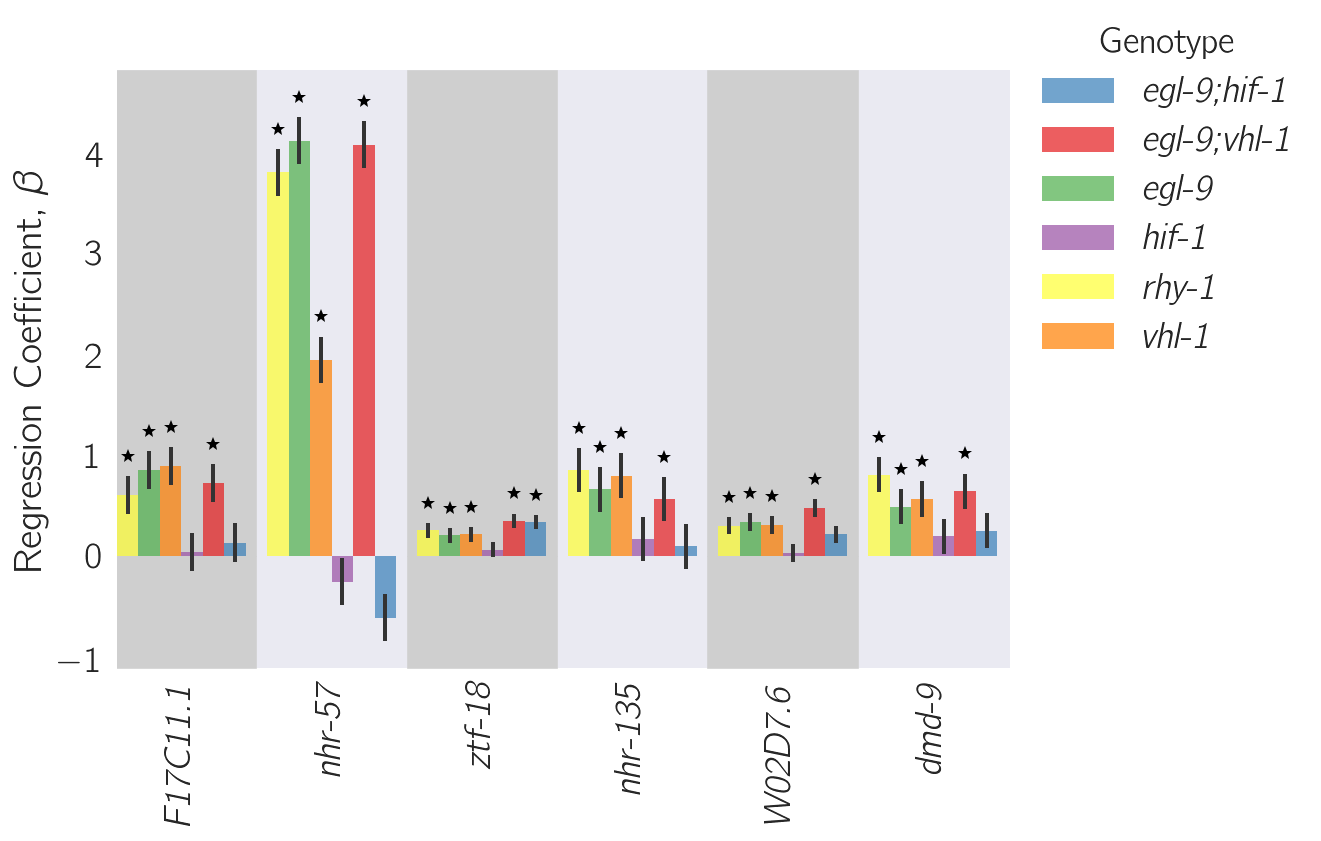

In [12]:
genpy.qPCR_plot(plotdf[plotdf.code != 'g'], genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id', rotation=90)

## A slightly less restrictive approach reveals even more Transcription Factors

In [13]:
genotypes = ['e', 'b', 'a']
common = epi.find_overlap(genotypes, tidy)

tfs_in_hif = tfs[tfs.target_id.isin(common)].target_id
print('There are {0} transcription factors in HIF-1+/HIF-1OH- animals'.format(tfs_in_hif.shape[0]))


plotdf = tidy[tidy.target_id.isin(tfs_in_hif)].copy()
plotdf.sort_values(['genotype', 'target_id'], inplace=True)
plot_order = {i: t+1 for t, i in enumerate(plotdf.target_id.unique())}
plotdf['order'] = plotdf.target_id.map(plot_order)
plotdf.sort_values('order', inplace=True)
plotdf.reset_index(inplace=True)  
plotdf = plotdf[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

There are 13 transcription factors in HIF-1+/HIF-1OH- animals


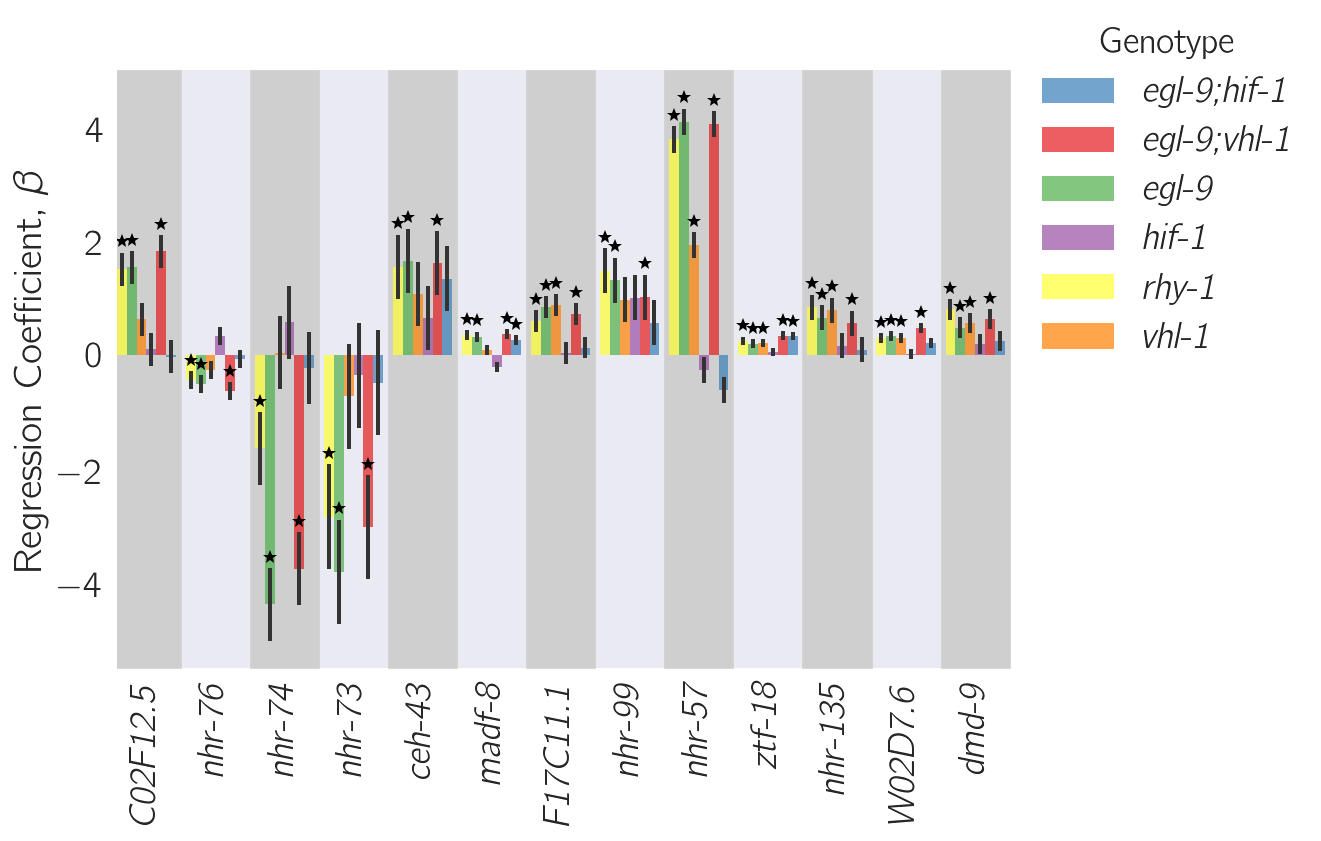

In [14]:
genpy.qPCR_plot(plotdf[plotdf.code != 'g'], genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id', rotation=90)

In [17]:
genotypes = ['c', 'f']
common = epi.find_overlap(genotypes, tidy)

tfs_without_hif = tfs[tfs.target_id.isin(common)].target_id
print('There are {0} transcription factors in HIF-1-/HIF-1OH- animals'.format(tfs_without_hif.shape[0]))


plotdf = tidy[tidy.target_id.isin(tfs_without_hif)].copy()
plotdf.sort_values(['genotype', 'target_id'], inplace=True)
plot_order = {i: t+1 for t, i in enumerate(plotdf.target_id.unique())}
plotdf['order'] = plotdf.target_id.map(plot_order)
plotdf.sort_values('order', inplace=True)
plotdf.reset_index(inplace=True)  
plotdf = plotdf[['target_id', 'ens_gene', 'ext_gene','b', 'se_b', 'qval', 'genotype', 'order', 'code']]

There are 1 transcription factors in HIF-1-/HIF-1OH- animals


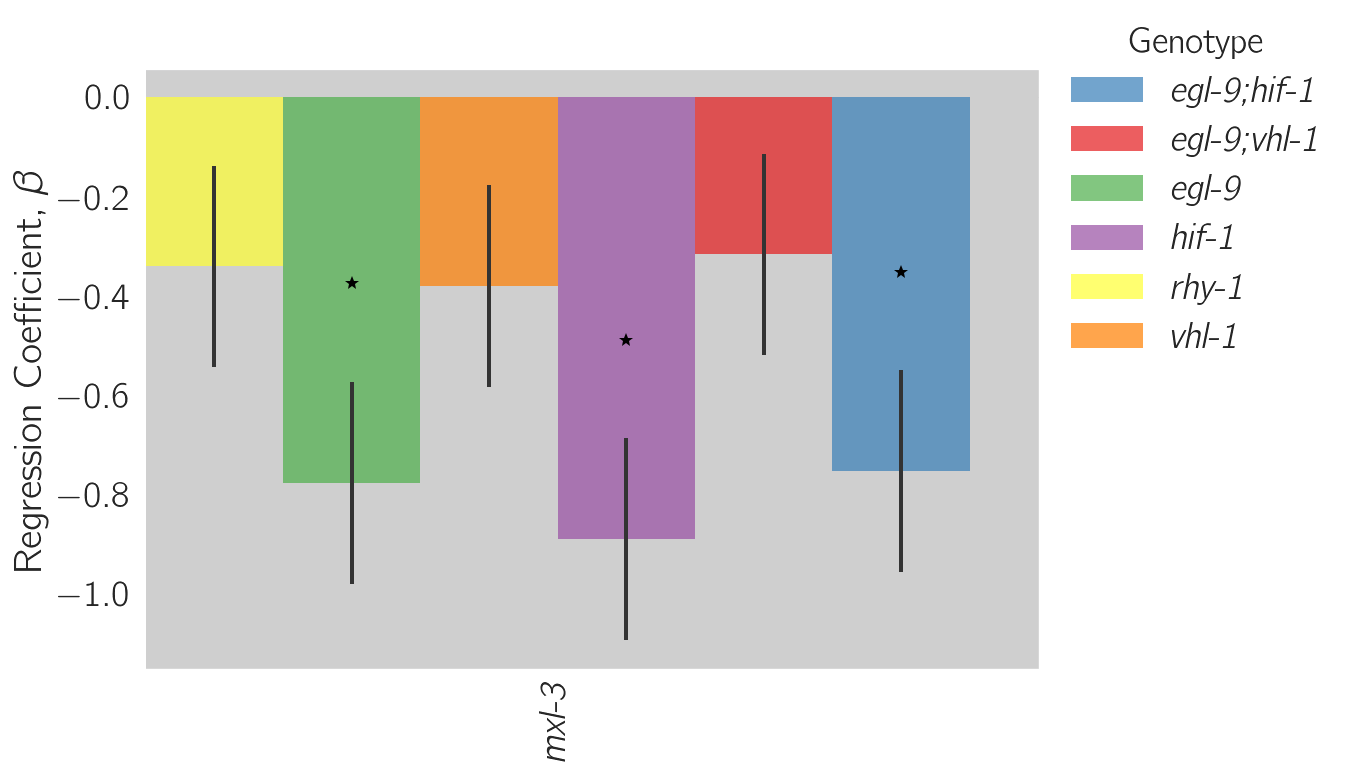

In [18]:
genpy.qPCR_plot(plotdf[plotdf.code != 'g'], genvar.plot_order, genvar.plot_color, clustering='genotype',
                plotting_group='target_id', rotation=90)